In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
from tensorflow import set_random_seed

In [18]:
from sklearn.model_selection import StratifiedKFold

In [5]:
def plotROC(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve, area = {:.2}'.format(auc(fpr, tpr)))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [6]:
features = numpy.loadtxt('modifiedTraining.csv', delimiter=',')
labels = numpy.loadtxt('labels.csv', delimiter=',')

In [7]:
features.shape

(15420, 159)

In [8]:
labels.shape

(15420,)

In [10]:
trainingX, testX, trainingY, testY = train_test_split(features, labels, test_size=0.3, random_state=1)

In [11]:
# using SMOTE for over-sampling
sm = SMOTE(kind='regular')

In [12]:
x, y = sm.fit_sample(trainingX, trainingY)

In [13]:
print('Number of fraudulent cases = {}\nNumber of true cases = {}'.format(sum(y[:] == 1), sum(y[:] == 0)))

Number of fraudulent cases = 10180
Number of true cases = 10180


In [14]:
# normalizing training data to zero mean and unit standard deviation
x -= numpy.mean(x, axis=0)
sd = numpy.std(x, axis=0)
sd[sd[:] == 0] = 1
x /= sd

In [15]:
ohe1 = OneHotEncoder()
ohe1.fit(y.reshape(-1,1))
transformedTrainingY = ohe1.transform(y.reshape(-1,1)).toarray()

In [16]:
testX -= numpy.mean(testX, axis=0)
sd = numpy.std(testX, axis=0)
sd[sd[:] == 0] = 1
testX /= sd

In [19]:
sKfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [17]:
callBack = EarlyStopping(patience=5)

In [21]:
sgd = SGD(lr=0.001, momentum=0.9)
set_random_seed(1)
numpy.random.seed(1)
cvs = []
for train, test in sKfold.split(x, y):
    model = Sequential()
    model.add(Dense(60, activation='relu', input_shape=(159,)))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd)
    model.fit(x[train], transformedTrainingY[train], batch_size = 32, epochs=50, verbose=0)
    loss, accuracy = model.evaluate(x[test], transformedTrainingY[test], verbose=2)
    print('Validation Loss = {} , Validation Accuracy = {}'.format(loss, accuracy))
    cvs.append(accuracy)
print('Mean Accuracy = ', numpy.mean(cvs))
print('Standard Deviation = ', numpy.std(cvs))

Validation Loss = 0.10696399560992283 , Validation Accuracy = 0.974950884086444
Validation Loss = 0.08067548739191416 , Validation Accuracy = 0.9739685658153242
Validation Loss = 0.10629360170482359 , Validation Accuracy = 0.9764243614931237
Validation Loss = 0.09428217261389249 , Validation Accuracy = 0.9769155206286837
Validation Loss = 0.07980455165319071 , Validation Accuracy = 0.9833005893909627
Validation Loss = 0.15409955578606416 , Validation Accuracy = 0.9675834970530451
Validation Loss = 0.10084305584068412 , Validation Accuracy = 0.9769155206286837
Validation Loss = 0.0975450304778721 , Validation Accuracy = 0.9774066797642437
Validation Loss = 0.1346016999650637 , Validation Accuracy = 0.9666011787819253
Validation Loss = 0.11501176788815624 , Validation Accuracy = 0.9680746561886051
Mean Accuracy =  0.9742141453831042
Standard Deviation =  0.0050244883394094456


### Retraining the model on entired dataset

In [22]:
model = Sequential()
model.add(Dense(60, activation='relu', input_shape=(159,)))
model.add(Dense(60, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.fit(x, transformedTrainingY, batch_size = 32, epochs=50, verbose=0)

In [23]:
loss, accuracy = model.evaluate(testX, ohe1.transform(testY.reshape(-1,1)).toarray(), verbose=2)
predicted = model.predict(testX)
print('Test Loss = {} , Test Accuracy = {}, AUC = {}'.format(loss, accuracy, roc_auc_score(testY, predicted[:,1])))
# Confusion Matrix
print(confusion_matrix(testY, numpy.argmax(predicted, axis=1)))

Test Loss = 0.8784766677739658 , Test Accuracy = 0.8335495027071256, AUC = 0.7381403242842889
[[3739  578]
 [ 192  117]]


In [24]:
fpr, tpr, _ = roc_curve(testY, predicted[:,1])

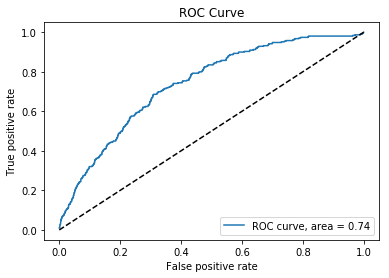

In [25]:
plotROC(fpr,tpr)

In [26]:
yPredicted = numpy.argmax(predicted, axis=1)

In [27]:
confusion_matrix(testY, yPredicted)

array([[3739,  578],
       [ 192,  117]])

In [28]:
precision_score(testY, yPredicted)

0.1683453237410072

In [29]:
recall_score(testY, yPredicted)

0.3786407766990291

In [30]:
f1_score(testY, yPredicted)

0.23306772908366538

In [31]:
accuracy_score(testY, yPredicted)

0.8335495028102032